## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Import Dataset

In [2]:
df = pd.read_csv('WineQT.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


- There is no missing values
- Data type for all columns already numeric
- Column Id can be set as index

In [5]:
# Check for nan values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

No missing values.

In [6]:
# Check for duplicates
# Set Id as index before checking
df.set_index('Id', inplace=True)

duplicate = df[df.duplicated()]
duplicate

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
91,8.6,0.490,0.28,1.90,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6
93,7.7,0.490,0.26,1.90,0.062,9.0,31.0,0.99660,3.39,0.64,9.6,5
102,8.1,0.545,0.18,1.90,0.080,13.0,35.0,0.99720,3.30,0.59,9.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,7.5,0.380,0.57,2.30,0.106,5.0,12.0,0.99605,3.36,0.55,11.4,6
1560,7.8,0.600,0.26,2.00,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,5
1561,7.8,0.600,0.26,2.00,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,5


There are 125 duplicated rows. We can drop these rows later.

In [7]:
# Check the label's distribution
df['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

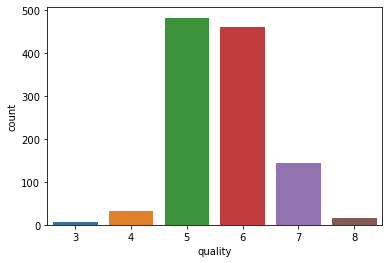

In [8]:
sns.countplot(x=df['quality'])
plt.show()

It seems that most of the data is filled with quality 5 and 6. This indicates that the dataset is imbalanced.

In [9]:
corr = df.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.250728,0.673157,0.171831,0.107889,-0.164831,-0.110628,0.681501,-0.685163,0.174592,-0.075055,0.121970
volatile acidity,-0.250728,1.000000,-0.544187,-0.005751,0.056336,-0.001962,0.077748,0.016512,0.221492,-0.276079,-0.203909,-0.407394
citric acid,0.673157,-0.544187,1.000000,0.175815,0.245312,-0.057589,0.036871,0.375243,-0.546339,0.331232,0.106250,0.240821
residual sugar,0.171831,-0.005751,0.175815,1.000000,0.070863,0.165339,0.190790,0.380147,-0.116959,0.017475,0.058421,0.022002
chlorides,0.107889,0.056336,0.245312,0.070863,1.000000,0.015280,0.048163,0.208901,-0.277759,0.374784,-0.229917,-0.124085
free sulfur dioxide,-0.164831,-0.001962,-0.057589,0.165339,0.015280,1.000000,0.661093,-0.054150,0.072804,0.034445,-0.047095,-0.063260
total sulfur dioxide,-0.110628,0.077748,0.036871,0.190790,0.048163,0.661093,1.000000,0.050175,-0.059126,0.026894,-0.188165,-0.183339
density,0.681501,0.016512,0.375243,0.380147,0.208901,-0.054150,0.050175,1.000000,-0.352775,0.143139,-0.494727,-0.175208
pH,-0.685163,0.221492,-0.546339,-0.116959,-0.277759,0.072804,-0.059126,-0.352775,1.000000,-0.185499,0.225322,-0.052453
sulphates,0.174592,-0.276079,0.331232,0.017475,0.374784,0.034445,0.026894,0.143139,-0.185499,1.000000,0.094421,0.257710


C:\Users\user\AppData\Local\Temp\ipykernel_15432\1610998572.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


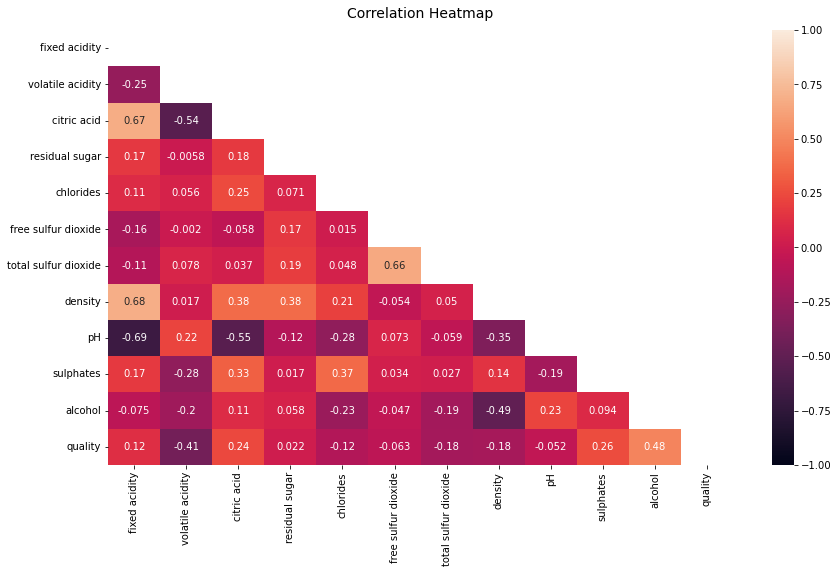

In [10]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

As we can see from the heatmap, there are 4 attributes which have high correlation with the label:
- violatile acidity
- citric acid
- sulphates
- alcohol

## Data Prepocessing

### Drop duplicates

In [11]:
df.drop_duplicates(keep="last", inplace=True)

In [12]:
duplicate = df[df.duplicated()]
duplicate

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,


### Encode label
Label is encoded because some models like Adaboost requires the label values start from 0. 

In [13]:
dict_quality = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5}
df['quality'] = df['quality'].apply(lambda x: dict_quality[x])

### Fixed imbalanced dataset

In [14]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [15]:
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8


In [16]:
y[:3]

Id
1    2
2    2
3    3
Name: quality, dtype: int64

In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

In [18]:
print(len(X_ros))

2598


In [19]:
# Check the label's distribution
y_ros.value_counts()

2    433
3    433
4    433
1    433
5    433
0    433
Name: quality, dtype: int64

### Data normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_ros)
X_scale = scaler.transform(X_ros)

X_scale[:5]

array([[0.28318584, 0.52054795, 0.        , 0.11643836, 0.14357262,
        0.35820896, 0.2155477 , 0.49412628, 0.36220472, 0.20958084,
        0.21538462],
       [0.28318584, 0.43835616, 0.04      , 0.09589041, 0.13355593,
        0.20895522, 0.16961131, 0.50881057, 0.40944882, 0.19161677,
        0.21538462],
       [0.5840708 , 0.10958904, 0.56      , 0.06849315, 0.10517529,
        0.23880597, 0.19081272, 0.58223201, 0.33070866, 0.1497006 ,
        0.21538462],
       [0.24778761, 0.39726027, 0.        , 0.06849315, 0.10684474,
        0.14925373, 0.09893993, 0.56754772, 0.60629921, 0.13772455,
        0.15384615],
       [0.24778761, 0.36986301, 0.        , 0.06164384, 0.10517529,
        0.17910448, 0.12014134, 0.56754772, 0.60629921, 0.13772455,
        0.15384615]])

### Split data to train and test

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y_ros, test_size=0.2, random_state=42)

In [22]:
X_train[:2]

array([[0.2920354 , 0.3630137 , 0.01      , 0.10958904, 0.11018364,
        0.23880597, 0.1130742 , 0.45741557, 0.47244094, 0.24550898,
        0.50769231],
       [0.18584071, 0.39726027, 0.08      , 0.19520548, 0.0918197 ,
        0.10447761, 0.03533569, 0.24008811, 0.54330709, 0.11377246,
        0.64615385]])

In [23]:
y_train[:2]

2174    4
931     2
Name: quality, dtype: int64

## Modelling

### Logistic Regression

In [24]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'C': [100, 1000, 10000],  
    'max_iter': [100, 1000, 10000], 
    'random_state': [42]}  

log = LogisticRegression()
grid_log = GridSearchCV(log, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_log = grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [25]:
print(grid_log.best_params_) 

{'C': 1000, 'max_iter': 1000, 'random_state': 42}


In [27]:
# Model prediction
y_pred_log = grid_log.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
print("Accuracy: ", acc_log)

Accuracy:  0.5865384615384616


In [28]:
print("Classification Report: \n", classification_report(y_test, y_pred_log))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        93
           1       0.59      0.50      0.54        86
           2       0.49      0.53      0.51        87
           3       0.52      0.38      0.44        92
           4       0.42      0.55      0.48        80
           5       0.58      0.54      0.56        82

    accuracy                           0.59       520
   macro avg       0.58      0.58      0.58       520
weighted avg       0.59      0.59      0.58       520



### SVM (Support Vector Machines)

In [29]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'gamma':['scale', 'auto'],
    'kernel': ['rbf', 'linear'],
    'random_state': [42]
    }  

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_svm = grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [30]:
print(grid_svm.best_params_) 

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}


In [31]:
# Model prediction
y_pred_svm = grid_svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy: ", acc_svm)

Accuracy:  0.8480769230769231


In [32]:
print("Classification Report: \n", classification_report(y_test, y_pred_svm))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        93
           1       0.90      1.00      0.95        86
           2       0.64      0.67      0.66        87
           3       0.68      0.52      0.59        92
           4       0.90      0.93      0.91        80
           5       0.94      1.00      0.97        82

    accuracy                           0.85       520
   macro avg       0.84      0.85      0.84       520
weighted avg       0.84      0.85      0.84       520



### Decision Tree

In [33]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [5, 10, 20, 50, 100], 
    'splitter' : ["best", "random"],
    'random_state': [42]
    }  

dtl = DecisionTreeClassifier()
grid_dtl = GridSearchCV(dtl, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_dtl = grid_dtl.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [34]:
print(grid_dtl.best_params_) 

{'criterion': 'gini', 'max_depth': 20, 'random_state': 42, 'splitter': 'best'}


In [35]:
# Model prediction
y_pred_dtl = grid_dtl.predict(X_test)

acc_dtl = accuracy_score(y_test, y_pred_dtl)
print("Accuracy: ", acc_dtl)

Accuracy:  0.8346153846153846


In [36]:
print("Classification Report: \n", classification_report(y_test, y_pred_dtl))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        93
           1       0.90      1.00      0.95        86
           2       0.65      0.52      0.58        87
           3       0.61      0.55      0.58        92
           4       0.82      0.96      0.89        80
           5       0.99      1.00      0.99        82

    accuracy                           0.83       520
   macro avg       0.82      0.84      0.83       520
weighted avg       0.82      0.83      0.83       520



### Random Forest

In [37]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'n_estimators': [100, 200, 500, 1000], 
    'max_depth' : [100, 200, 500],
    'random_state': [42]
    }  

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_rf = grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [38]:
print(grid_rf.best_params_) 

{'criterion': 'gini', 'max_depth': 100, 'n_estimators': 500, 'random_state': 42}


In [39]:
# Model prediction
y_pred_rf = grid_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy: ", acc_rf)

Accuracy:  0.8692307692307693


In [40]:
print("Classification Report: \n", classification_report(y_test, y_pred_rf))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       0.99      1.00      0.99        86
           2       0.66      0.68      0.67        87
           3       0.69      0.57      0.62        92
           4       0.85      1.00      0.92        80
           5       1.00      1.00      1.00        82

    accuracy                           0.87       520
   macro avg       0.87      0.87      0.87       520
weighted avg       0.86      0.87      0.86       520



### Adaboost

In [41]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 1, 5, 10],  
    'n_estimators': [50, 100, 200, 500], 
    'random_state': [42]
    }  

ada = AdaBoostClassifier()
grid_ada = GridSearchCV(ada, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_ada = grid_ada.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [42]:
print(grid_ada.best_params_) 

{'learning_rate': 0.01, 'n_estimators': 50, 'random_state': 42}


In [43]:
# Model prediction
y_pred_ada = grid_ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy: ", acc_ada)

Accuracy:  0.47884615384615387


In [44]:
print("Classification Report: \n", classification_report(y_test, y_pred_ada))

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.53      0.23      0.32        86
           2       0.44      0.66      0.53        87
           3       0.33      0.42      0.37        92
           4       0.34      0.50      0.41        80
           5       0.00      0.00      0.00        82

    accuracy                           0.48       520
   macro avg       0.41      0.47      0.42       520
weighted avg       0.41      0.48      0.43       520



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

In [45]:
# Search the best hyperparameters using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 1],  
    'n_estimators': [50, 100, 200, 500], 
    'max_leaves': [0, 10, 20, 50, 100],
    'random_state': [42]
    }  

xg = xgb.XGBClassifier()
grid_xg = GridSearchCV(xg, param_grid, refit=True, verbose=3, n_jobs=-1, cv=5) 
grid_xg = grid_xg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [46]:
print(grid_xg.best_params_) 

{'learning_rate': 0.1, 'max_leaves': 0, 'n_estimators': 500, 'random_state': 42}


In [47]:
# Model prediction
y_pred_xg = grid_xg.predict(X_test)

acc_xg = accuracy_score(y_test, y_pred_xg)
print("Accuracy: ", acc_xg)

Accuracy:  0.8692307692307693


In [48]:
print("Classification Report: \n", classification_report(y_test, y_pred_xg))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       0.99      1.00      0.99        86
           2       0.66      0.69      0.67        87
           3       0.68      0.57      0.62        92
           4       0.90      0.99      0.94        80
           5       0.98      1.00      0.99        82

    accuracy                           0.87       520
   macro avg       0.87      0.87      0.87       520
weighted avg       0.86      0.87      0.87       520



## Model Selection

In [49]:
print("Accuracy of Logistic Regression:", acc_log)
print("Accuracy of SVM:", acc_svm)
print("Accuracy of Decision Tree:", acc_dtl)
print("Accuracy of Random Forest:", acc_rf)
print("Accuracy of Adaboost:", acc_ada)
print("Accuracy of XGBoost:", acc_xg)

Accuracy of Logistic Regression: 0.5865384615384616
Accuracy of SVM: 0.8480769230769231
Accuracy of Decision Tree: 0.8346153846153846
Accuracy of Random Forest: 0.8692307692307693
Accuracy of Adaboost: 0.47884615384615387
Accuracy of XGBoost: 0.8692307692307693


In [50]:
accs = {
    'Logistic Regression': acc_log,
    'SVM': acc_svm,
    'Decision Tree': acc_dtl,
    'Random Forest': acc_rf,
    'Adaboost': acc_ada,
    'XGBoost': acc_xg}

best_model = max(accs, key=accs.get)
print(f"The best model is {best_model} with accuracy {round(accs[best_model], 4)}")

The best model is Random Forest with accuracy 0.8692


## Save Model

In [51]:
# Saving the model
import pickle
filename = 'wine_quality_clf.pkl'
pickle.dump(grid_rf, open(filename, 'wb'))

In [52]:
# Test the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8692307692307693
